# Import packages

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error

# Data Loading
- Mengunduh dan meng-ekstrak dataset.
- dataset yang digunakan: meirnizri/cellphones-recommendations

In [ ]:
from google.colab import files
files.upload()

# Create kaggle folder and move file
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d meirnizri/cellphones-recommendations
!unzip cellphones-recommendations.zip

Dataset URL: https://www.kaggle.com/datasets/meirnizri/cellphones-recommendations
License(s): ODbL-1.0
  0% 0.00/5.23k [00:00<?, ?B/s]
100% 5.23k/5.23k [00:00<00:00, 21.7MB/s]
Archive:  cellphones-recommendations.zip
  inflating: cellphones data.csv     
  inflating: cellphones ratings.csv  
  inflating: cellphones users.csv    


# Data Understanding
Pada proyek kali ini kita memiliki 3 file terpisah sebagai dataset.
- Membaca masing-masing file dataset.
- Melakukan pengecekan nilai unik pada tiap dataset.

In [ ]:
cp_df = pd.read_csv('cellphones data.csv')
ratings_df = pd.read_csv('cellphones ratings.csv')
users_df = pd.read_csv('cellphones users.csv')

In [ ]:
cp_df.head()

,cellphone_id,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date
0,0,Apple,iPhone SE (2022),iOS,128,4,7.23,12,7,2018,4.7,144,429,18/03/2022
1,1,Apple,iPhone 13 Mini,iOS,128,4,7.72,12,12,2438,5.4,141,699,24/09/2021
2,2,Apple,iPhone 13,iOS,128,4,7.75,12,12,3240,6.1,174,699,24/09/2021
3,3,Apple,iPhone 13 Pro,iOS,256,6,7.94,12,12,3065,6.1,204,999,24/09/2021
4,4,Apple,iPhone 13 Pro Max,iOS,256,6,8.01,12,12,4352,6.7,240,1199,24/09/2021


In [ ]:
ratings_df.head()

,user_id,cellphone_id,rating
0,0,30,1
1,0,5,3
2,0,10,9
3,0,9,3
4,0,23,2


In [ ]:
users_df.head()

,user_id,age,gender,occupation
0,0,38,Female,Data analyst
1,1,40,Female,team worker in it
2,6,55,Female,IT
3,8,25,Female,Manager
4,10,23,Male,worker


In [ ]:
print('Jumlah data cellphones: ', len(cp_df.cellphone_id.unique()))
print('Jumlah data users: ', len(users_df.user_id.unique()))

Jumlah data cellphones:  33
Jumlah data users:  99


# Exploratory Data Analysis

## Univariate Exploratory Data Analysis

### Cellphones Data
- Mengecek fitur pada dataset.
- Mengecek perseberan fitur numerik.
- Mengecek persebaran fitur categorikal (brand)

In [ ]:
cp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cellphone_id      33 non-null     int64  
 1   brand             33 non-null     object 
 2   model             33 non-null     object 
 3   operating system  33 non-null     object 
 4   internal memory   33 non-null     int64  
 5   RAM               33 non-null     int64  
 6   performance       33 non-null     float64
 7   main camera       33 non-null     int64  
 8   selfie camera     33 non-null     int64  
 9   battery size      33 non-null     int64  
 10  screen size       33 non-null     float64
 11  weight            33 non-null     int64  
 12  price             33 non-null     int64  
 13  release date      33 non-null     object 
dtypes: float64(2), int64(8), object(4)
memory usage: 3.7+ KB


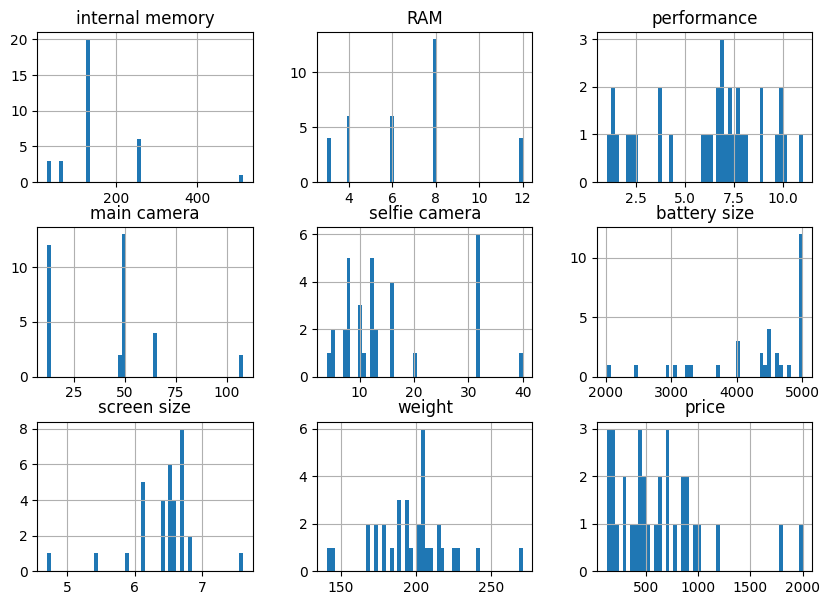

In [ ]:
cp_df.drop('cellphone_id', axis=1).hist(bins=50, figsize=(10,7))
plt.show()

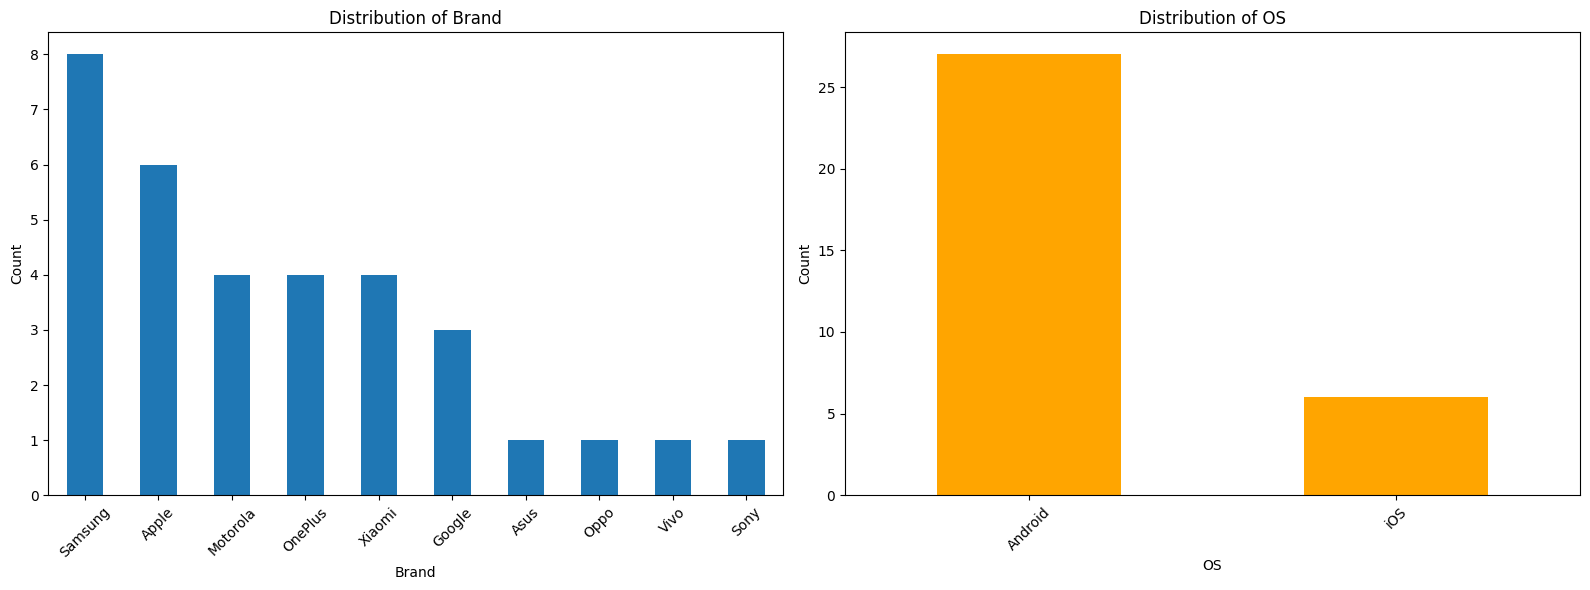

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for Brand
cp_df['brand'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribution of Brand')
axes[0].set_xlabel('Brand')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plot for OS
cp_df['operating system'].value_counts().plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Distribution of OS')
axes[1].set_xlabel('OS')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

1. Data menunjukkan bahwa mayoritas ponsel memiliki kapasitas memori internal sebesar 128 GB.
2. Dari segi RAM, ponsel dengan kapasitas 8 GB paling banyak ditemukan.
3. Nilai performa dan harga ponsel cukup bervariasi, tanpa adanya dominasi yang mencolok dari satu model tertentu.
4. Kamera utama yang paling umum digunakan memiliki resolusi 50 MP.
5. Untuk kamera depan (selfie camera), resolusi yang paling banyak digunakan adalah 32 MP.
6. Ukuran baterai yang paling sering ditemukan adalah 5000 mAh.
7 .Ukuran layar paling banyak berada pada rentang 6,0 hingga 7,0 inci.
8. Berat ponsel bervariasi, namun paling banyak berada pada kisaran 200–210 gram.
9. Samsung merupakan merek dengan jumlah tipe ponsel terbanyak dalam data yang dianalisis.

### Ratings Data
- Mengecek fitur pada dataset.
- Mengecek perseberan fitur numerik.

In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       990 non-null    int64
 1   cellphone_id  990 non-null    int64
 2   rating        990 non-null    int64
dtypes: int64(3)
memory usage: 23.3 KB


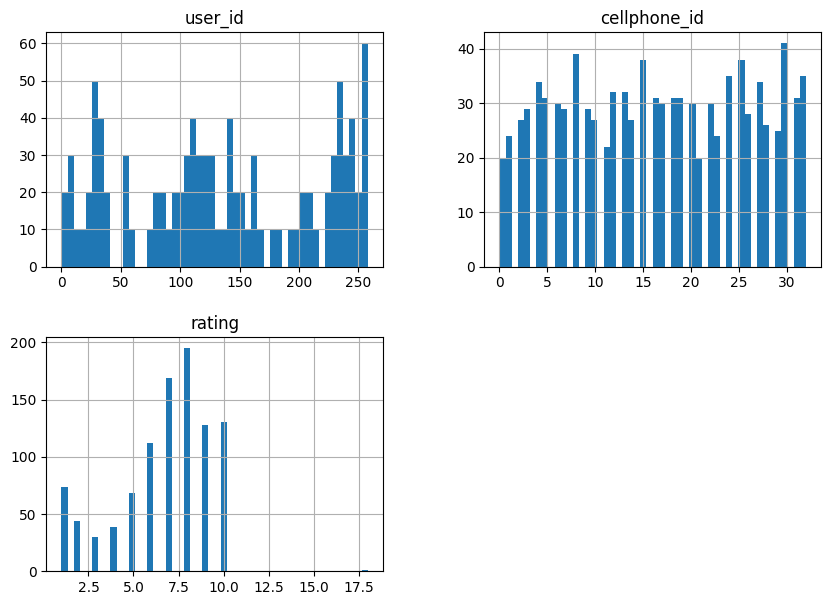

In [ ]:
ratings_df.hist(bins=50, figsize=(10,7))
plt.show()

1. User ID: Aktivitas pengguna bervariasi; sebagian sangat aktif, sebagian hanya memberi sedikit ulasan.
2. Cellphone ID: Jumlah ulasan per ponsel cukup merata, tiap model mendapat ulasan yang seimbang.
3. Rating: Mayoritas rating berada di kisaran 6–9, menunjukkan kecenderungan penilaian positif dari pengguna.Namun terdapat outlier untuk nilai diatas 10.


### User Data
- Mengecek fitur pada dataset.
- Mengecek perseberan fitur numerik.
- Mengecek persebaran fitur categorikal.

In [ ]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     99 non-null     int64 
 1   age         99 non-null     int64 
 2   gender      99 non-null     object
 3   occupation  98 non-null     object
dtypes: int64(2), object(2)
memory usage: 3.2+ KB


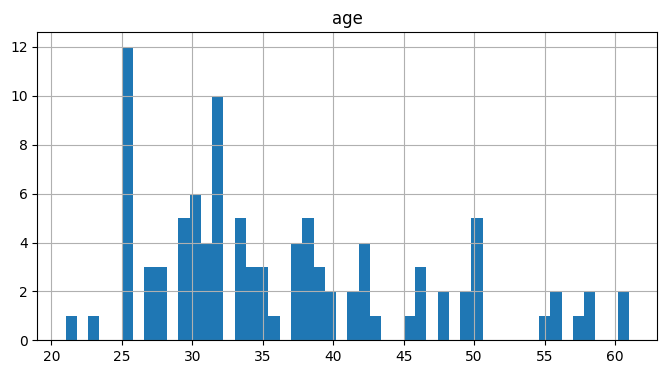

In [ ]:
users_df.drop('user_id', axis=1).hist(bins=50, figsize=(8,4))
plt.show()

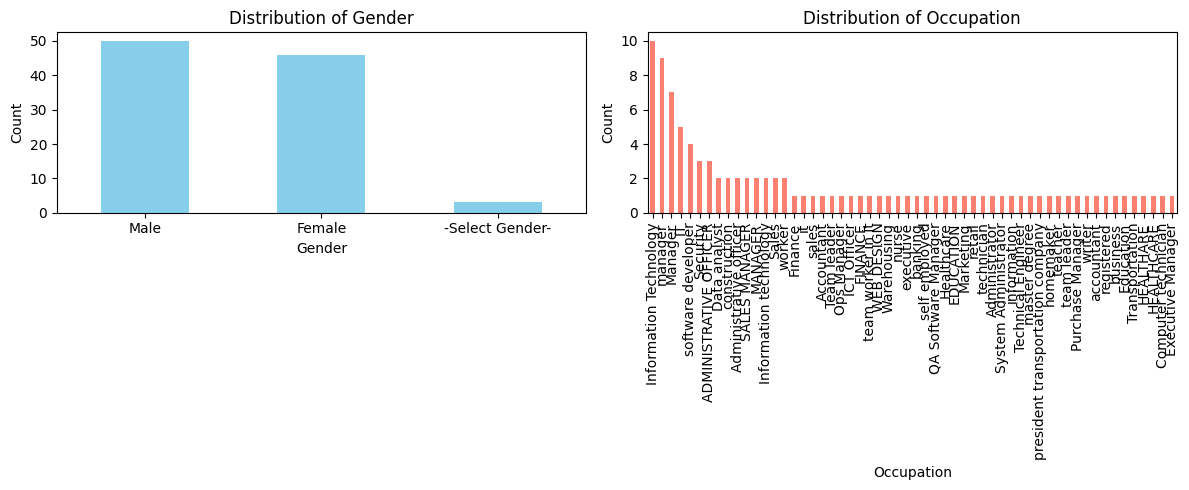

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
users_df['gender'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
users_df['occupation'].value_counts().plot(kind='bar', color='salmon')
plt.title('Distribution of Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

- Persebaran umur pada dataset users cukup bervariasi, namun didominasi oleh pengguna berumur 25 tahun.
- Persebaran jenis kelamin tidak berbeda jauh antara laki-laki dan perempuan. Tetapi terdapat outlier pada beberapa data.
- Information Technology merupakan pekerjaan yang paling umum di antara pengguna, diikuti oleh Manager dan Developer.

# Data Prepartion

## Handling Outlier
- Menghapus baris pada data rating yang memiliki rating diatas 10.
- Mengganti nilai data gender yang bernilai '-Select Gender-' dengan 'Unspecified'.


In [ ]:
ratings_df = ratings_df[ratings_df['rating'] <= 10]

In [ ]:
users_df['gender'] = users_df['gender'].replace('-Select Gender-', 'Unspecified')

### Content Filtering Prep
- Scaling data untuk numerikal fitur pada dataset cellphones.
- Menggunakan One-Hot encoding untuk kategorikal fitur. (Disini kita hanya memiliki 10 brand dan 2 OS saja)

In [ ]:
numerical_features = [
    'performance', 'internal memory', 'RAM', 'main camera',
    'selfie camera', 'battery size', 'screen size', 'weight', 'price'
]
scaler = StandardScaler()
X_numeric = scaler.fit_transform(cp_df[numerical_features])
X_categorical = pd.get_dummies(cp_df[['brand', 'operating system']])
content_df = np.hstack([X_numeric, X_categorical.values])
content_df

array([[ 0.35577652, -0.22429447, -1.04356963, -1.13045395, -0.85919489,
        -2.85603517, -3.69717698, -2.13523731, -0.46640926,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.52822576, -0.22429447, -1.04356963, -1.13045395, -0.35288361,
        -2.33510229, -2.20408628, -2.25527621,  0.16554124,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.53878387, -0.22429447, -1.04356963, -1.13045395, -0.35288361,
        -1.34036856, -0.71099557, -0.93484836,  0.16554124,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.60565194,  1.18555647, -0.29492185, -1.13045395

## Collaborative filtering Prep
- Menyandikan (encode) fitur user_id dan ‘cellphone_id’ ke dalam indeks integer.
- Memetakan user_id dan ‘cellphone_id’ ke dataframe yang berkaitan.
- Mengubah nilai rating menjadi float.
- Mengacak data pada rating.
- Mengubah nilai rating menjadi skala 0 hingga 1.
- Membagi data train dan validasi dengan komposisi 80:20

In [ ]:
cl_rating_df = ratings_df.copy()
# Encoding data user_id
user_ids = cl_rating_df['user_id'].unique().tolist()
print('list user_id: ', user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded number to user_ids: ', user_encoded_to_user)

# encoding data cellphones
cellphone_ids = cl_rating_df['cellphone_id'].unique().tolist()
print('list cellphone_ids:', cellphone_ids)

cp_to_cp_encoded = {x: i for i, x in enumerate(cellphone_ids)}
print('encoded cellphone_id : ', cp_to_cp_encoded)

cp_encoded_to_cp = {i: x for i, x in enumerate(cellphone_ids)}
print('encoded number to cellphone_id: ', cp_encoded_to_cp)

list user_id:  [0, 1, 6, 8, 10, 12, 16, 24, 25, 26, 27, 28, 29, 30, 32, 33, 35, 36, 37, 38, 52, 53, 56, 60, 74, 79, 80, 84, 85, 91, 95, 98, 99, 100, 104, 105, 106, 110, 111, 112, 113, 114, 115, 116, 119, 120, 123, 124, 126, 128, 129, 137, 140, 142, 143, 144, 145, 148, 152, 154, 156, 160, 162, 164, 169, 178, 183, 194, 200, 203, 204, 208, 211, 215, 226, 227, 230, 231, 232, 233, 234, 235, 236, 237, 238, 240, 242, 243, 244, 245, 246, 251, 252, 253, 254, 255, 256, 257, 258]
encoded user_id :  {0: 0, 1: 1, 6: 2, 8: 3, 10: 4, 12: 5, 16: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 11, 29: 12, 30: 13, 32: 14, 33: 15, 35: 16, 36: 17, 37: 18, 38: 19, 52: 20, 53: 21, 56: 22, 60: 23, 74: 24, 79: 25, 80: 26, 84: 27, 85: 28, 91: 29, 95: 30, 98: 31, 99: 32, 100: 33, 104: 34, 105: 35, 106: 36, 110: 37, 111: 38, 112: 39, 113: 40, 114: 41, 115: 42, 116: 43, 119: 44, 120: 45, 123: 46, 124: 47, 126: 48, 128: 49, 129: 50, 137: 51, 140: 52, 142: 53, 143: 54, 144: 55, 145: 56, 148: 57, 152: 58, 154: 59, 156: 60, 160:

In [ ]:
cl_rating_df['user'] = cl_rating_df['user_id'].map(user_to_user_encoded)
cl_rating_df['cellphone'] = cl_rating_df['cellphone_id'].map(cp_to_cp_encoded)

In [ ]:
cl_rating_df['rating'] = cl_rating_df['rating'].values.astype(np.float32)

In [ ]:
min_rating = min(cl_rating_df['rating'])

max_rating = max(cl_rating_df['rating'])

num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah resto
num_cp = len(cp_to_cp_encoded)
print(num_cp)
print(min_rating, max_rating)

99
33
1.0 10.0


In [ ]:
cl_rating_df = cl_rating_df.sample(frac=1, random_state=42)
cl_rating_df

,user_id,cellphone_id,rating,user,cellphone
213,53,4,9.0,21,16
331,100,27,9.0,33,19
501,129,4,8.0,50,16
309,95,5,5.0,30,1
88,25,16,9.0,8,7
...,...,...,...,...,...
106,27,6,8.0,10,27
270,84,25,1.0,27,21
860,242,24,4.0,86,30
435,116,13,1.0,43,17


In [ ]:
x = cl_rating_df[['user', 'cellphone']].values
y = cl_rating_df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
train_indices = int(0.8 * cl_rating_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[21 16]
 [33 19]
 [50 16]
 ...
 [86 30]
 [43 17]
 [10  8]] [0.88888889 0.88888889 0.77777778 0.44444444 0.88888889 0.66666667
 0.         0.88888889 0.55555556 0.66666667 1.         0.22222222
 0.88888889 1.         0.66666667 0.88888889 0.55555556 0.66666667
 0.77777778 0.77777778 0.44444444 0.11111111 0.66666667 0.55555556
 0.66666667 0.22222222 0.55555556 0.55555556 0.77777778 0.55555556
 0.11111111 0.77777778 0.77777778 0.88888889 0.44444444 0.55555556
 0.22222222 0.66666667 0.33333333 0.88888889 0.66666667 0.11111111
 0.55555556 0.77777778 0.77777778 0.55555556 0.88888889 0.88888889
 0.66666667 0.88888889 0.44444444 1.         1.         0.55555556
 0.55555556 0.77777778 0.55555556 0.66666667 0.44444444 0.88888889
 0.33333333 0.77777778 0.66666667 0.         0.33333333 0.77777778
 0.77777778 0.77777778 0.55555556 0.44444444 0.66666667 0.66666667
 0.44444444 0.66666667 1.         0.66666667 1.         0.88888889
 0.66666667 1.         0.88888889 0.88888889 0.11111111 0.77777778
 0

# Modeling and Result

In [ ]:
item_features = ['model', 'brand',  'operating system', 'internal memory', 'RAM', 'performance' ,'main camera', 'selfie camera', 'battery size', 'screen size', 'weight','price']

## Content Filtering
- Menghitung kesamaan (similarity) mengunakan fungsi cosine_similarity.
- Membuat dataframe berdasarkan hasil cosine dengan baris dan kolom berupa model.
- Membuat fungsi untuk mencari rekomendasi.
- Melakukan percobaan pada salah satu model hp.

In [ ]:
similarity_matrix = cosine_similarity(content_df)
similarity_matrix

array([[ 1.        ,  0.96291432,  0.83014877, ...,  0.01611288,
         0.25624417, -0.11387285],
       [ 0.96291432,  1.        ,  0.91410908, ..., -0.03583748,
         0.22657776, -0.19396297],
       [ 0.83014877,  0.91410908,  1.        , ...,  0.07933662,
         0.29142545, -0.15492946],
       ...,
       [ 0.01611288, -0.03583748,  0.07933662, ...,  1.        ,
         0.92365852,  0.90297832],
       [ 0.25624417,  0.22657776,  0.29142545, ...,  0.92365852,
         1.        ,  0.81778842],
       [-0.11387285, -0.19396297, -0.15492946, ...,  0.90297832,
         0.81778842,  1.        ]])

In [ ]:
content_sim_df = pd.DataFrame(similarity_matrix, index=cp_df['model'], columns=cp_df['model'])
print('Shape:', content_sim_df.shape)
content_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (33, 33)


model,Galaxy Z Fold 3,Nord 2T,Galaxy S22,Galaxy A32,11T Pro
model,,,,,
iPhone 13 Pro,0.221946,-0.320276,0.154485,-0.480141,-0.317946
iPhone XR,-0.333660,-0.241252,0.144609,0.270815,-0.546391
Moto G Power (2022),-0.196831,0.054527,-0.141773,0.867127,0.067313
Galaxy Z Fold 3,1.000000,-0.246587,-0.223113,-0.163811,0.044466
Moto G Play (2021),-0.132015,-0.076311,-0.167398,0.789915,-0.288246
10T,0.263363,0.402523,0.277474,-0.139596,0.405621
12 Pro,0.099116,0.631082,0.091954,-0.122169,0.443499
iPhone SE (2022),-0.532095,-0.128981,0.538432,-0.150820,-0.395548
Galaxy A32,-0.163811,0.173837,-0.030768,1.000000,0.071667


In [ ]:
def cellphones_recommendations(model, similarity_data=content_sim_df, items=cp_df[item_features], k=5):
    index = similarity_data.loc[:, model].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(model, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)


In [ ]:
cp_df[cp_df.model.eq('iPhone 13')]

,cellphone_id,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date
2,2,Apple,iPhone 13,iOS,128,4,7.75,12,12,3240,6.1,174,699,24/09/2021


In [ ]:
content_recom = cellphones_recommendations('iPhone 13')
content_recom

,model,brand,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price
0,iPhone 13 Mini,Apple,iOS,128,4,7.72,12,12,2438,5.4,141,699
1,iPhone SE (2022),Apple,iOS,128,4,7.23,12,7,2018,4.7,144,429
2,iPhone XR,Apple,iOS,64,3,4.22,12,7,2942,6.1,194,236
3,iPhone 13 Pro,Apple,iOS,256,6,7.94,12,12,3065,6.1,204,999
4,Pixel 6a,Google,Android,128,6,6.88,12,8,4410,6.1,178,449


## Colaborative Filtering
- Membuat class RecommenderNet dengan keras Model class.
- Melakukan proses `compile` pada model.
- Melakuka proses `training`.
- Mecoba melakukan proses rekomendasi


In [ ]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_cp, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_cp = num_cp
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.cp_embedding = layers.Embedding(
        num_cp,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.cp_bias = layers.Embedding(num_cp, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    cp_vector = self.cp_embedding(inputs[:, 1])
    cp_bias = self.cp_bias(inputs[:, 1])

    dot_user_cp = tf.tensordot(user_vector, cp_vector, 2)

    x = dot_user_cp + user_bias + cp_bias

    return tf.nn.sigmoid(x)

In [ ]:
model = RecommenderNet(num_users, num_cp, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7602 - root_mean_squared_error: 0.3608 - val_loss: 0.7318 - val_root_mean_squared_error: 0.3377
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7015 - root_mean_squared_error: 0.3311 - val_loss: 0.7278 - val_root_mean_squared_error: 0.3350
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7015 - root_mean_squared_error: 0.3350 - val_loss: 0.7224 - val_root_mean_squared_error: 0.3313
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6821 - root_mean_squared_error: 0.3107 - val_loss: 0.7180 - val_root_mean_squared_error: 0.3281
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6870 - root_mean_squared_error: 0.3140 - val_loss: 0.7168 - val_root_mean_squared_error: 0.3274
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6464 - root_mean_squared_error: 0.2837 - val_loss: 0.7134 - val_root_mean_squared_error: 0.3251
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

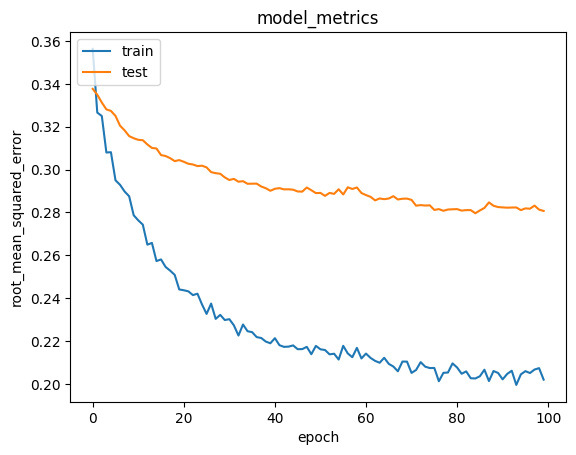

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
user_id = ratings_df.user_id.sample(1).iloc[0]
owned_cp_by_user = ratings_df[ratings_df.user_id == user_id]

cp_not_owned = cl_rating_df[~cl_rating_df['cellphone_id'].isin(owned_cp_by_user.cellphone_id.values)]['cellphone_id']
cp_not_owned = list(
    set(cp_not_owned)
    .intersection(set(cp_to_cp_encoded.keys()))
)

cp_not_owned_encoded = [[cp_to_cp_encoded[x]] for x in cp_not_owned]
user_encoder = user_to_user_encoded.get(user_id)
user_cp_array = np.hstack(
    ([[user_encoder]] * len(cp_not_owned_encoded), cp_not_owned_encoded)
)

In [ ]:
ratings = model.predict(user_cp_array).flatten()
top_indices = ratings.argsort()[-10:][::-1]
recommended_cellphone_ids = [
    cp_encoded_to_cp[i[0]] for i in np.array(cp_not_owned_encoded)[top_indices]
]
recommended_cellphones = cp_df[cp_df['cellphone_id'].isin(recommended_cellphone_ids)][item_features].drop_duplicates()
print(recommended_cellphones)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
                model    brand operating system  internal memory  RAM  \
0    iPhone SE (2022)    Apple              iOS              128    4   
1      iPhone 13 Mini    Apple              iOS              128    4   
2           iPhone 13    Apple              iOS              128    4   
4   iPhone 13 Pro Max    Apple              iOS              256    6   
12   Galaxy S22 Ultra  Samsung          Android              128    8   
17       Pixel 6 Pro    Google          Android              128   12   
20             10 Pro  OnePlus          Android              128    8   
25            11T Pro   Xiaomi          Android              256    8   
26             12 Pro   Xiaomi          Android              128    8   
28         Xperia Pro     Sony          Android              512   12   

    performance  main camera  selfie camera  battery size  screen size  \
0          7.23           12              7          2018          4.7   
1        

# Evaluation

## Content Filtering
- Mengunakan percision@k untuk menguji sistem dengan pre-defined ground truth.

In [ ]:
# Evaluation function: Precision@K
def precision_at_k(recommend_fn, ground_truth, k=5):
    precisions = []
    for item in ground_truth:
        recommended = recommend_fn(item)[:k]
        relevant = ground_truth[item]
        if not relevant:
            continue
        precision = len(set(recommended['model']) & set(relevant)) / k
        precisions.append(precision)
    return sum(precisions) / len(precisions)

ground_truth = {
    'iPhone SE (2022)': ['iPhone 13 Mini', 'iPhone 13', 'iPhone XR'],
    'iPhone 13 Mini': ['iPhone SE (2022)', 'iPhone 13', 'Galaxy S22'],
    'iPhone 13': ['iPhone 13 Mini', 'iPhone SE (2022)', 'iPhone XR'],
    'iPhone 13 Pro': ['iPhone 13', 'Xperia Pro', 'iPhone 13 Pro Max'],
    'iPhone 13 Pro Max': ['Galaxy Z Fold 3', 'Xperia Pro', 'iPhone 13 Pro']
}


precision_score = precision_at_k(cellphones_recommendations, ground_truth, k=5)
precision_score


0.5599999999999999

## Colaborative filtering
- Menggunakan rmse untuk mengevaluasi model, disini menggunakan nilai rmse pada epoch terakhir pada saat traning.

In [ ]:
last_val_rmse = history.history['val_root_mean_squared_error'][-1]
print(f"Last validation RMSE: {last_val_rmse:.4f}")

Last validation RMSE: 0.2807
